# Experiment 6: Pose MLP - Enhanced Feature Engineering

Robust comparison of pose-based models using **30-run aggregated statistics** with config-based training.

## Configurations

| Config | Features | Description |
|--------|----------|-------------|
| **A** (Baseline) | 19 | 13 joint angles + 6 distances |
| **B** (Specialized) | 37 | Base + 18 specialized discrimination features |

**Key Features:**
- Enhanced pose features with specialized discrimination for confusion clusters
- Temporal sequences (50 timesteps × N features)
- Subject-wise stratified train/val/test splits (no subject leakage)
- 30 runs per configuration with different random seeds
- Comprehensive statistical analysis and visualization

In [1]:
from pathlib import Path
import sys
import numpy as np

PROJECT_ROOT = Path('..').resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Force reload modules to pick up latest changes
import importlib
import src.data.data_loader
import src.data.dataset_builder
import src.scripts.experiment_6
importlib.reload(src.data.data_loader)
importlib.reload(src.data.dataset_builder)
importlib.reload(src.scripts.experiment_6)

from src.data.data_loader import load_pose_enhanced_data
from src.scripts.experiment_6 import train_experiment_6_multi_run

print("✅ Modules loaded successfully")

✅ Modules loaded successfully


In [2]:
importlib.reload(src.utils.visualization)

from src.utils.visualization import (
    plot_confusion_matrix_from_metrics,
    plot_per_class_f1_scores,
    sort_labels_by_numeric_prefix,
    display_multi_run_summary,
    plot_multi_run_distributions,
    plot_best_worst_comparison,
    plot_aggregated_confusion_matrix,
    plot_dual_training_history,
    compare_multi_run_stats,
)
import matplotlib.pyplot as plt
import pandas as pd

print("✅ Visualization functions loaded")

✅ Visualization functions loaded


---

## Configuration Selection

Select which configuration to run. Available options:

- **`A`** - Baseline: 19 features (13 angles + 6 distances)
- **`B`** - Base + Specialized: 37 features (19 + 18 specialized discrimination features)

In [11]:
# ============================================================
# 🔧 CONFIGURATION SELECTION - MODIFY THIS CELL
# ============================================================

# Select configuration: 'A' or 'B'
SELECTED_CONFIG = 'A'

# Select view: 'front' or 'side'
SELECTED_VIEW = 'side'

# ============================================================
# Configuration mappings (DO NOT MODIFY)
# ============================================================

CONFIG_MAP = {
    'A': {
        'name': 'Baseline',
        'feature_type': 'all',
        'num_features': 19,
        'config_front': 'experiment_6_temporal_front.yaml',
        'config_side': 'experiment_6_temporal_side.yaml',
        'description': '13 joint angles + 6 distances'
    },
    'B': {
        'name': 'Base + Specialized',
        'feature_type': 'base_specialized',
        'num_features': 37,
        'config_front': 'experiment_6_ablation_specialized_front.yaml',
        'config_side': 'experiment_6_ablation_specialized_side.yaml',
        'description': '19 base + 18 specialized discrimination features'
    }
}

# Get selected configuration
config_info = CONFIG_MAP[SELECTED_CONFIG]
config_file = config_info[f'config_{SELECTED_VIEW}']

print("=" * 60)
print(f"📋 SELECTED CONFIGURATION: {SELECTED_CONFIG} - {config_info['name']}")
print("=" * 60)
print(f"  View: {SELECTED_VIEW.upper()}")
print(f"  Feature type: {config_info['feature_type']}")
print(f"  Number of features: {config_info['num_features']}")
print(f"  Description: {config_info['description']}")
print(f"  Config file: {config_file}")
print("=" * 60)

📋 SELECTED CONFIGURATION: A - Baseline
  View: SIDE
  Feature type: all
  Number of features: 19
  Description: 13 joint angles + 6 distances
  Config file: experiment_6_temporal_side.yaml


---

## Data Loading

Load and summarize the enhanced pose feature dataset for the selected view.

In [6]:
# Define paths to enhanced pose NPZ files
npz_paths = {
    'front': PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_front_19_features.npz',
    'side': PROJECT_ROOT / 'datasets' / 'Mediapipe pose estimates' / 'pose_data_side_19_features.npz'
}

# Load data for selected view
npz_path = npz_paths[SELECTED_VIEW]
feature_type = config_info['feature_type']

dataset, summary = load_pose_enhanced_data(str(npz_path), feature_type=feature_type)

print(f"\n📊 {SELECTED_VIEW.upper()} VIEW - {config_info['name']} Features:")
print(f"  Samples: {summary['count']}")
print(f"  Subjects: {summary['unique_subjects']}")
print(f"  Classes: {summary['unique_classes']}")
print(f"  Temporal shape: {summary['temporal_shape']} (timesteps × features)")
print(f"  Flattened to: {summary['temporal_shape'][0] * summary['temporal_shape'][1]} features per sample")
print(f"\n  Feature names ({len(summary['feature_names'])}):")
for i, name in enumerate(summary['feature_names'][:10]):
    print(f"    {i+1}. {name}")
if len(summary['feature_names']) > 10:
    print(f"    ... and {len(summary['feature_names']) - 10} more")

INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)



📊 FRONT VIEW - Base + Specialized Features:
  Samples: 1574
  Subjects: 49
  Classes: 15
  Temporal shape: (50, 37) (timesteps × features)
  Flattened to: 1850 features per sample

  Feature names (37):
    1. left_elbow
    2. right_elbow
    3. left_shoulder
    4. right_shoulder
    5. left_hip
    6. right_hip
    7. left_knee
    8. right_knee
    9. torso_lean
    10. left_ankle
    ... and 27 more


---

## Multi-Run Training (30 Runs)

Execute 30 training runs with different random seeds using the selected configuration.

In [7]:
# Train model with multi-run (30 runs)
print("=" * 80)
print(f"MULTI-RUN TRAINING: CONFIG {SELECTED_CONFIG} ({config_info['name']}) - {SELECTED_VIEW.upper()} VIEW")
print("=" * 80)

config_path = PROJECT_ROOT / 'config' / config_file

multi_run_results, aggregated_stats = train_experiment_6_multi_run(
    npz_path=str(npz_path),
    config_path=str(config_path)
)

print(f"\n✅ Config {SELECTED_CONFIG} ({SELECTED_VIEW} view) multi-run training complete!")
print(f"Mean Test Accuracy: {aggregated_stats['test_accuracy']['mean']:.4f} ± {aggregated_stats['test_accuracy']['std']:.4f}")
print(f"Mean Test Macro F1: {aggregated_stats['test_macro_f1']['mean']:.4f} ± {aggregated_stats['test_macro_f1']['std']:.4f}")

INFO - Multi-run parent folder: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011
INFO - 
INFO - Starting run 1/30 (seed=43)
INFO - ================================================================================
INFO - Global random seed set to: 43


MULTI-RUN TRAINING: CONFIG C (Base + Specialized) - FRONT VIEW


INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=895, val=285, test=394, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.1430 - loss: 3.0719 - val_accuracy: 0.5368 - val_loss: 1.8166 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3017 - loss: 2.1423 - val_accuracy: 0.7263 - val_loss: 1.3874 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4536 - loss: 1.7324 - val_accuracy: 0.7614 - val_loss: 1.1061 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5397 - loss: 1.4319 - val_accuracy: 0.7860 - val_loss: 0.8877 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6112 - loss: 1.2136 - val_accuracy: 0.8211 - val_loss: 0.7208 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6872 - loss: 1.0258 - val_accuracy: 0.8596 - val_loss: 0.5976 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7162

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_001/model.keras
INFO - Run 1 complete: acc=0.8376, macro_f1=0.8367
INFO - 
INFO - Starting run 2/30 (seed=44)
INFO - ================================================================================
INFO - Global random seed set to: 44
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=949, val=228, test=397, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.1675 - loss: 2.9289 - val_accuracy: 0.5570 - val_loss: 1.6284 - learning_rate: 5.0000e-05
Epoch 2/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3825 - loss: 1.9745 - val_accuracy: 0.7061 - val_loss: 1.2187 - learning_rate: 5.0000e-05
Epoch 3/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5047 - loss: 1.5344 - val_accuracy: 0.8070 - val_loss: 0.9637 - learning_rate: 5.0000e-05
Epoch 4/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6228 - loss: 1.2211 - val_accuracy: 0.8640 - val_loss: 0.7772 - learning_rate: 5.0000e-05
Epoch 5/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6617 - loss: 1.0833 - val_accuracy: 0.8816 - val_loss: 0.6492 - learning_rate: 5.0000e-05
Epoch 6/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7050 - loss: 0.9421 - val_accuracy: 0.9211 - val_loss: 0.5219 - learning_rate: 5.0000e-05
Epoch 7/220
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7850

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_002/model.keras
INFO - Run 2 complete: acc=0.9219, macro_f1=0.9174
INFO - 
INFO - Starting run 3/30 (seed=45)
INFO - ================================================================================
INFO - Global random seed set to: 45
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=912, val=240, test=422, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1721 - loss: 2.8672 - val_accuracy: 0.4875 - val_loss: 1.7132 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3377 - loss: 2.0238 - val_accuracy: 0.6875 - val_loss: 1.2827 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5055 - loss: 1.5725 - val_accuracy: 0.7708 - val_loss: 1.0493 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5976 - loss: 1.3187 - val_accuracy: 0.8458 - val_loss: 0.8459 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6831 - loss: 1.0415 - val_accuracy: 0.8625 - val_loss: 0.7042 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7368 - loss: 0.8960 - val_accuracy: 0.8667 - val_loss: 0.5996 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7566

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_003/model.keras
INFO - Run 3 complete: acc=0.9194, macro_f1=0.9146
INFO - 
INFO - Starting run 4/30 (seed=46)
INFO - ================================================================================
INFO - Global random seed set to: 46
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=829, val=286, test=459, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.1218 - loss: 3.0705 - val_accuracy: 0.4615 - val_loss: 1.8874 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2919 - loss: 2.2204 - val_accuracy: 0.7378 - val_loss: 1.4187 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4077 - loss: 1.7699 - val_accuracy: 0.8462 - val_loss: 1.1023 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5416 - loss: 1.4542 - val_accuracy: 0.8916 - val_loss: 0.8848 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5935 - loss: 1.2403 - val_accuracy: 0.8986 - val_loss: 0.7191 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 1.1029 - val_accuracy: 0.8881 - val_loss: 0.6071 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7310

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_004/model.keras
INFO - Run 4 complete: acc=0.8780, macro_f1=0.8800
INFO - 
INFO - Starting run 5/30 (seed=47)
INFO - ================================================================================
INFO - Global random seed set to: 47
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
WARNING - Val split missing classes (acceptable): ['Deadlift', 'Calf raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=828, val=219, test=527, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.1582 - loss: 3.1611 - val_accuracy: 0.5571 - val_loss: 1.7859 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2971 - loss: 2.1918 - val_accuracy: 0.7352 - val_loss: 1.2871 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4082 - loss: 1.7175 - val_accuracy: 0.7397 - val_loss: 0.9821 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5604 - loss: 1.3701 - val_accuracy: 0.7945 - val_loss: 0.8116 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6171 - loss: 1.1920 - val_accuracy: 0.8402 - val_loss: 0.7030 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6763 - loss: 0.9575 - val_accuracy: 0.8584 - val_loss: 0.6131 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7258

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_005/model.keras
INFO - Run 5 complete: acc=0.9450, macro_f1=0.9423
INFO - 
INFO - Starting run 6/30 (seed=48)
INFO - ================================================================================
INFO - Global random seed set to: 48
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=920, val=214, test=440, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.1739 - loss: 2.9385 - val_accuracy: 0.5187 - val_loss: 1.7501 - learning_rate: 5.0000e-05
Epoch 2/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3848 - loss: 1.9431 - val_accuracy: 0.7243 - val_loss: 1.2521 - learning_rate: 5.0000e-05
Epoch 3/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4685 - loss: 1.5861 - val_accuracy: 0.8879 - val_loss: 0.9493 - learning_rate: 5.0000e-05
Epoch 4/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5957 - loss: 1.2622 - val_accuracy: 0.8925 - val_loss: 0.7574 - learning_rate: 5.0000e-05
Epoch 5/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7109 - loss: 0.9635 - val_accuracy: 0.9299 - val_loss: 0.6076 - learning_rate: 5.0000e-05
Epoch 6/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7467 - loss: 0.8664 - val_accuracy: 0.9252 - val_loss: 0.5025 - learning_rate: 5.0000e-05
Epoch 7/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_006/model.keras
INFO - Run 6 complete: acc=0.8614, macro_f1=0.8652
INFO - 
INFO - Starting run 7/30 (seed=49)
INFO - ================================================================================
INFO - Global random seed set to: 49
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=930, val=243, test=401, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1516 - loss: 3.0045 - val_accuracy: 0.4856 - val_loss: 1.8397 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3495 - loss: 2.0191 - val_accuracy: 0.5638 - val_loss: 1.4459 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5000 - loss: 1.5695 - val_accuracy: 0.5761 - val_loss: 1.2147 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5667 - loss: 1.2920 - val_accuracy: 0.6584 - val_loss: 1.0491 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6548 - loss: 1.0558 - val_accuracy: 0.6749 - val_loss: 0.9256 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7204 - loss: 0.9041 - val_accuracy: 0.7160 - val_loss: 0.8133 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7548

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_007/model.keras
INFO - Run 7 complete: acc=0.8853, macro_f1=0.8812
INFO - 
INFO - Starting run 8/30 (seed=50)
INFO - ================================================================================
INFO - Global random seed set to: 50
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=905, val=259, test=410, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.1547 - loss: 2.9397 - val_accuracy: 0.4479 - val_loss: 1.9147 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3470 - loss: 2.0504 - val_accuracy: 0.7799 - val_loss: 1.4350 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5293 - loss: 1.5172 - val_accuracy: 0.8610 - val_loss: 1.0907 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6298 - loss: 1.2455 - val_accuracy: 0.8803 - val_loss: 0.8558 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7083 - loss: 0.9839 - val_accuracy: 0.8880 - val_loss: 0.6982 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7315 - loss: 0.8777 - val_accuracy: 0.8803 - val_loss: 0.5808 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7890

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_008/model.keras
INFO - Run 8 complete: acc=0.8512, macro_f1=0.8636
INFO - 
INFO - Starting run 9/30 (seed=51)
INFO - ================================================================================
INFO - Global random seed set to: 51
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=936, val=212, test=426, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1207 - loss: 3.0924 - val_accuracy: 0.6274 - val_loss: 1.8819 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3600 - loss: 2.0545 - val_accuracy: 0.7311 - val_loss: 1.4509 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5021 - loss: 1.5864 - val_accuracy: 0.7972 - val_loss: 1.1447 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6100 - loss: 1.2400 - val_accuracy: 0.7500 - val_loss: 0.9675 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6752 - loss: 1.0226 - val_accuracy: 0.7972 - val_loss: 0.8300 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7062 - loss: 0.8769 - val_accuracy: 0.7877 - val_loss: 0.7223 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7575

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_009/model.keras
INFO - Run 9 complete: acc=0.7606, macro_f1=0.7727
INFO - 
INFO - Starting run 10/30 (seed=52)
INFO - ================================================================================
INFO - Global random seed set to: 52
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=816, val=254, test=504, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.1164 - loss: 3.0651 - val_accuracy: 0.4016 - val_loss: 1.9791 - learning_rate: 5.0000e-05
Epoch 2/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2819 - loss: 2.2264 - val_accuracy: 0.7008 - val_loss: 1.5600 - learning_rate: 5.0000e-05
Epoch 3/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4436 - loss: 1.7674 - val_accuracy: 0.7598 - val_loss: 1.2867 - learning_rate: 5.0000e-05
Epoch 4/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5355 - loss: 1.4059 - val_accuracy: 0.7874 - val_loss: 1.0863 - learning_rate: 5.0000e-05
Epoch 5/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6385 - loss: 1.1804 - val_accuracy: 0.7953 - val_loss: 0.9374 - learning_rate: 5.0000e-05
Epoch 6/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6900 - loss: 1.0411 - val_accuracy: 0.8031 - val_loss: 0.8153 - learning_rate: 5.0000e-05
Epoch 7/220
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7194

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_010/model.keras
INFO - Run 10 complete: acc=0.8810, macro_f1=0.8782
INFO - 
INFO - Starting run 11/30 (seed=53)
INFO - ================================================================================
INFO - Global random seed set to: 53
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
WARNING - Val split missing classes (acceptable): ['Deadlift', 'Calf raises']
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=926, val=223, test=425, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.1361 - loss: 3.1264 - val_accuracy: 0.5740 - val_loss: 1.8326 - learning_rate: 5.0000e-05
Epoch 2/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3326 - loss: 2.1179 - val_accuracy: 0.6592 - val_loss: 1.4479 - learning_rate: 5.0000e-05
Epoch 3/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4903 - loss: 1.6428 - val_accuracy: 0.6906 - val_loss: 1.1994 - learning_rate: 5.0000e-05
Epoch 4/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5994 - loss: 1.3163 - val_accuracy: 0.7444 - val_loss: 1.0301 - learning_rate: 5.0000e-05
Epoch 5/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6825 - loss: 1.0676 - val_accuracy: 0.7758 - val_loss: 0.8952 - learning_rate: 5.0000e-05
Epoch 6/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7009 - loss: 0.9562 - val_accuracy: 0.7937 - val_loss: 0.7933 - learning_rate: 5.0000e-05
Epoch 7/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7549

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_011/model.keras
INFO - Run 11 complete: acc=0.8471, macro_f1=0.8268
INFO - 
INFO - Starting run 12/30 (seed=54)
INFO - ================================================================================
INFO - Global random seed set to: 54
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=843, val=300, test=431, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.1151 - loss: 3.2356 - val_accuracy: 0.4667 - val_loss: 1.9990 - learning_rate: 5.0000e-05
Epoch 2/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2716 - loss: 2.3383 - val_accuracy: 0.6600 - val_loss: 1.5731 - learning_rate: 5.0000e-05
Epoch 3/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4223 - loss: 1.8239 - val_accuracy: 0.7200 - val_loss: 1.2687 - learning_rate: 5.0000e-05
Epoch 4/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5042 - loss: 1.5111 - val_accuracy: 0.7533 - val_loss: 1.0364 - learning_rate: 5.0000e-05
Epoch 5/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6263 - loss: 1.2343 - val_accuracy: 0.8067 - val_loss: 0.8582 - learning_rate: 5.0000e-05
Epoch 6/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6928 - loss: 1.0311 - val_accuracy: 0.8267 - val_loss: 0.7296 - learning_rate: 5.0000e-05
Epoch 7/220
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7153

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_012/model.keras
INFO - Run 12 complete: acc=0.8770, macro_f1=0.8765
INFO - 
INFO - Starting run 13/30 (seed=55)
INFO - ================================================================================
INFO - Global random seed set to: 55
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=927, val=192, test=455, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.1575 - loss: 2.9066 - val_accuracy: 0.5208 - val_loss: 1.7964 - learning_rate: 5.0000e-05
Epoch 2/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3193 - loss: 2.0473 - val_accuracy: 0.6250 - val_loss: 1.4278 - learning_rate: 5.0000e-05
Epoch 3/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4876 - loss: 1.5385 - val_accuracy: 0.6615 - val_loss: 1.1848 - learning_rate: 5.0000e-05
Epoch 4/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5804 - loss: 1.2117 - val_accuracy: 0.6927 - val_loss: 0.9956 - learning_rate: 5.0000e-05
Epoch 5/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6839 - loss: 0.9865 - val_accuracy: 0.7396 - val_loss: 0.8343 - learning_rate: 5.0000e-05
Epoch 6/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7379 - loss: 0.8369 - val_accuracy: 0.7708 - val_loss: 0.7655 - learning_rate: 5.0000e-05
Epoch 7/220
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7875

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_013/model.keras
INFO - Run 13 complete: acc=0.8637, macro_f1=0.8785
INFO - 
INFO - Starting run 14/30 (seed=56)
INFO - ================================================================================
INFO - Global random seed set to: 56
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=898, val=228, test=448, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1470 - loss: 3.1094 - val_accuracy: 0.4561 - val_loss: 1.7980 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3107 - loss: 2.1517 - val_accuracy: 0.7500 - val_loss: 1.2777 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 1.6855 - val_accuracy: 0.7939 - val_loss: 0.9873 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5635 - loss: 1.3705 - val_accuracy: 0.8070 - val_loss: 0.7939 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6080 - loss: 1.2166 - val_accuracy: 0.8640 - val_loss: 0.6496 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7361 - loss: 0.9568 - val_accuracy: 0.9035 - val_loss: 0.5036 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7439

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_014/model.keras
INFO - Run 14 complete: acc=0.9219, macro_f1=0.9263
INFO - 
INFO - Starting run 15/30 (seed=57)
INFO - ================================================================================
INFO - Global random seed set to: 57
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=892, val=243, test=439, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.1390 - loss: 3.1772 - val_accuracy: 0.5514 - val_loss: 1.8162 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3296 - loss: 2.1484 - val_accuracy: 0.7778 - val_loss: 1.3056 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5045 - loss: 1.6511 - val_accuracy: 0.8230 - val_loss: 0.9959 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 1.3868 - val_accuracy: 0.8354 - val_loss: 0.8270 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6738 - loss: 1.0586 - val_accuracy: 0.8601 - val_loss: 0.6848 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7074 - loss: 0.9367 - val_accuracy: 0.8477 - val_loss: 0.6055 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7309

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_015/model.keras
INFO - Run 15 complete: acc=0.8724, macro_f1=0.8745
INFO - 
INFO - Starting run 16/30 (seed=58)
INFO - ================================================================================
INFO - Global random seed set to: 58
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=866, val=240, test=468, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1501 - loss: 3.0046 - val_accuracy: 0.5458 - val_loss: 1.9188 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3533 - loss: 2.0917 - val_accuracy: 0.6958 - val_loss: 1.4616 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4908 - loss: 1.6405 - val_accuracy: 0.7333 - val_loss: 1.1634 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5543 - loss: 1.3800 - val_accuracy: 0.7792 - val_loss: 0.9535 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6513 - loss: 1.1443 - val_accuracy: 0.8417 - val_loss: 0.7655 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7206 - loss: 0.9330 - val_accuracy: 0.8458 - val_loss: 0.6568 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7483

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_016/model.keras
INFO - Run 16 complete: acc=0.8632, macro_f1=0.8650
INFO - 
INFO - Starting run 17/30 (seed=59)
INFO - ================================================================================
INFO - Global random seed set to: 59
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=869, val=272, test=433, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.1047 - loss: 3.0827 - val_accuracy: 0.4632 - val_loss: 2.0712 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3222 - loss: 2.0479 - val_accuracy: 0.5478 - val_loss: 1.6650 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4994 - loss: 1.5951 - val_accuracy: 0.5993 - val_loss: 1.4217 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5880 - loss: 1.3244 - val_accuracy: 0.6618 - val_loss: 1.2489 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6364 - loss: 1.1341 - val_accuracy: 0.6728 - val_loss: 1.1365 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7227 - loss: 0.9445 - val_accuracy: 0.6838 - val_loss: 1.0423 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7664

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_017/model.keras
INFO - Run 17 complete: acc=0.8614, macro_f1=0.8497
INFO - 
INFO - Starting run 18/30 (seed=60)
INFO - ================================================================================
INFO - Global random seed set to: 60
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=880, val=272, test=422, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1159 - loss: 3.1947 - val_accuracy: 0.5221 - val_loss: 1.9236 - learning_rate: 5.0000e-05
Epoch 2/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3023 - loss: 2.1849 - val_accuracy: 0.6875 - val_loss: 1.4670 - learning_rate: 5.0000e-05
Epoch 3/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4989 - loss: 1.6125 - val_accuracy: 0.7243 - val_loss: 1.2129 - learning_rate: 5.0000e-05
Epoch 4/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5591 - loss: 1.3626 - val_accuracy: 0.7500 - val_loss: 1.0153 - learning_rate: 5.0000e-05
Epoch 5/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6523 - loss: 1.1107 - val_accuracy: 0.8015 - val_loss: 0.8419 - learning_rate: 5.0000e-05
Epoch 6/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7102 - loss: 0.9606 - val_accuracy: 0.7978 - val_loss: 0.7430 - learning_rate: 5.0000e-05
Epoch 7/220
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7830

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_018/model.keras
INFO - Run 18 complete: acc=0.8246, macro_f1=0.8272
INFO - 
INFO - Starting run 19/30 (seed=61)
INFO - ================================================================================
INFO - Global random seed set to: 61
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=889, val=290, test=395, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.1395 - loss: 3.0479 - val_accuracy: 0.5586 - val_loss: 1.7116 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3667 - loss: 2.0263 - val_accuracy: 0.7448 - val_loss: 1.1912 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4713 - loss: 1.6724 - val_accuracy: 0.7621 - val_loss: 0.9357 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5883 - loss: 1.3261 - val_accuracy: 0.8138 - val_loss: 0.7475 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6682 - loss: 1.0708 - val_accuracy: 0.8414 - val_loss: 0.6098 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7222 - loss: 0.9059 - val_accuracy: 0.8414 - val_loss: 0.5355 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7525

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_019/model.keras
INFO - Run 19 complete: acc=0.8456, macro_f1=0.8519
INFO - 
INFO - Starting run 20/30 (seed=62)
INFO - ================================================================================
INFO - Global random seed set to: 62
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=883, val=301, test=390, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.1359 - loss: 3.1075 - val_accuracy: 0.5681 - val_loss: 1.7918 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3205 - loss: 2.0980 - val_accuracy: 0.7409 - val_loss: 1.3599 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4417 - loss: 1.6777 - val_accuracy: 0.8173 - val_loss: 1.0741 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5379 - loss: 1.4353 - val_accuracy: 0.8140 - val_loss: 0.9053 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6070 - loss: 1.2039 - val_accuracy: 0.8272 - val_loss: 0.7687 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6818 - loss: 1.0070 - val_accuracy: 0.8339 - val_loss: 0.6566 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7282

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_020/model.keras
INFO - Run 20 complete: acc=0.8974, macro_f1=0.9026
INFO - 
INFO - Starting run 21/30 (seed=63)
INFO - ================================================================================
INFO - Global random seed set to: 63
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=830, val=249, test=495, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1699 - loss: 2.8252 - val_accuracy: 0.6466 - val_loss: 1.6938 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3373 - loss: 2.0221 - val_accuracy: 0.7631 - val_loss: 1.2696 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4940 - loss: 1.6064 - val_accuracy: 0.7871 - val_loss: 1.0288 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6084 - loss: 1.2605 - val_accuracy: 0.8233 - val_loss: 0.8698 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6711 - loss: 1.0876 - val_accuracy: 0.8353 - val_loss: 0.7349 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7386 - loss: 0.8645 - val_accuracy: 0.8554 - val_loss: 0.6442 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7639

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_021/model.keras
INFO - Run 21 complete: acc=0.8525, macro_f1=0.8537
INFO - 
INFO - Starting run 22/30 (seed=64)
INFO - ================================================================================
INFO - Global random seed set to: 64
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=883, val=239, test=452, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1540 - loss: 3.0675 - val_accuracy: 0.4812 - val_loss: 1.9238 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3001 - loss: 2.1626 - val_accuracy: 0.6778 - val_loss: 1.4389 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4496 - loss: 1.6801 - val_accuracy: 0.8243 - val_loss: 1.1082 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5629 - loss: 1.3502 - val_accuracy: 0.8243 - val_loss: 0.8938 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6297 - loss: 1.1795 - val_accuracy: 0.8201 - val_loss: 0.7305 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7123 - loss: 0.9526 - val_accuracy: 0.8243 - val_loss: 0.6194 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7497

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_022/model.keras
INFO - Run 22 complete: acc=0.8805, macro_f1=0.8618
INFO - 
INFO - Starting run 23/30 (seed=65)
INFO - ================================================================================
INFO - Global random seed set to: 65
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=904, val=255, test=415, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1338 - loss: 3.1937 - val_accuracy: 0.4745 - val_loss: 1.8920 - learning_rate: 5.0000e-05
Epoch 2/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3219 - loss: 2.1050 - val_accuracy: 0.6706 - val_loss: 1.4113 - learning_rate: 5.0000e-05
Epoch 3/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4956 - loss: 1.6270 - val_accuracy: 0.8039 - val_loss: 1.0950 - learning_rate: 5.0000e-05
Epoch 4/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5796 - loss: 1.3125 - val_accuracy: 0.8627 - val_loss: 0.8640 - learning_rate: 5.0000e-05
Epoch 5/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 1.0433 - val_accuracy: 0.8745 - val_loss: 0.6953 - learning_rate: 5.0000e-05
Epoch 6/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7279 - loss: 0.8888 - val_accuracy: 0.9020 - val_loss: 0.5650 - learning_rate: 5.0000e-05
Epoch 7/220
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7533

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_023/model.keras
INFO - Run 23 complete: acc=0.8289, macro_f1=0.8287
INFO - 
INFO - Starting run 24/30 (seed=66)
INFO - ================================================================================
INFO - Global random seed set to: 66
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=940, val=280, test=354, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.1702 - loss: 2.9042 - val_accuracy: 0.6250 - val_loss: 1.6106 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3298 - loss: 1.9630 - val_accuracy: 0.7964 - val_loss: 1.2102 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4989 - loss: 1.5515 - val_accuracy: 0.8357 - val_loss: 0.9376 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 1.2552 - val_accuracy: 0.8536 - val_loss: 0.7284 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6723 - loss: 1.0343 - val_accuracy: 0.8714 - val_loss: 0.5974 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7053 - loss: 0.9170 - val_accuracy: 0.8607 - val_loss: 0.5271 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7617

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_024/model.keras
INFO - Run 24 complete: acc=0.8785, macro_f1=0.8891
INFO - 
INFO - Starting run 25/30 (seed=67)
INFO - ================================================================================
INFO - Global random seed set to: 67
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=885, val=241, test=448, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1311 - loss: 3.0238 - val_accuracy: 0.5726 - val_loss: 1.8214 - learning_rate: 5.0000e-05
Epoch 2/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3458 - loss: 2.0697 - val_accuracy: 0.6971 - val_loss: 1.3750 - learning_rate: 5.0000e-05
Epoch 3/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4893 - loss: 1.5760 - val_accuracy: 0.7635 - val_loss: 1.1253 - learning_rate: 5.0000e-05
Epoch 4/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5616 - loss: 1.3094 - val_accuracy: 0.8008 - val_loss: 0.9387 - learning_rate: 5.0000e-05
Epoch 5/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6780 - loss: 1.0425 - val_accuracy: 0.8299 - val_loss: 0.7938 - learning_rate: 5.0000e-05
Epoch 6/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7254 - loss: 0.8857 - val_accuracy: 0.7967 - val_loss: 0.6961 - learning_rate: 5.0000e-05
Epoch 7/220
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7367

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_025/model.keras
INFO - Run 25 complete: acc=0.8862, macro_f1=0.8874
INFO - 
INFO - Starting run 26/30 (seed=68)
INFO - ================================================================================
INFO - Global random seed set to: 68
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=824, val=251, test=499, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.1590 - loss: 2.8655 - val_accuracy: 0.5538 - val_loss: 1.8494 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3386 - loss: 2.1191 - val_accuracy: 0.6414 - val_loss: 1.4219 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4879 - loss: 1.6650 - val_accuracy: 0.6972 - val_loss: 1.1571 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5510 - loss: 1.4048 - val_accuracy: 0.7331 - val_loss: 0.9798 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6396 - loss: 1.1594 - val_accuracy: 0.7450 - val_loss: 0.8806 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6978 - loss: 0.9765 - val_accuracy: 0.7769 - val_loss: 0.7686 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7330

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_026/model.keras
INFO - Run 26 complete: acc=0.8377, macro_f1=0.8098
INFO - 
INFO - Starting run 27/30 (seed=69)
INFO - ================================================================================
INFO - Global random seed set to: 69
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=824, val=277, test=473, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.1529 - loss: 2.8421 - val_accuracy: 0.6101 - val_loss: 1.7162 - learning_rate: 5.0000e-05
Epoch 2/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3483 - loss: 2.0470 - val_accuracy: 0.6643 - val_loss: 1.3267 - learning_rate: 5.0000e-05
Epoch 3/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4709 - loss: 1.6559 - val_accuracy: 0.7004 - val_loss: 1.1326 - learning_rate: 5.0000e-05
Epoch 4/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5692 - loss: 1.3398 - val_accuracy: 0.6895 - val_loss: 0.9940 - learning_rate: 5.0000e-05
Epoch 5/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6942 - loss: 1.0247 - val_accuracy: 0.7437 - val_loss: 0.8351 - learning_rate: 5.0000e-05
Epoch 6/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7245 - loss: 0.9337 - val_accuracy: 0.7870 - val_loss: 0.7273 - learning_rate: 5.0000e-05
Epoch 7/220
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7476

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_027/model.keras
INFO - Run 27 complete: acc=0.8541, macro_f1=0.8544
INFO - 
INFO - Starting run 28/30 (seed=70)
INFO - ================================================================================
INFO - Global random seed set to: 70
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=854, val=284, test=436, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.1218 - loss: 3.0503 - val_accuracy: 0.4894 - val_loss: 1.8701 - learning_rate: 5.0000e-05
Epoch 2/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3150 - loss: 2.1070 - val_accuracy: 0.7254 - val_loss: 1.4121 - learning_rate: 5.0000e-05
Epoch 3/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4742 - loss: 1.6507 - val_accuracy: 0.7641 - val_loss: 1.1563 - learning_rate: 5.0000e-05
Epoch 4/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5925 - loss: 1.3355 - val_accuracy: 0.8169 - val_loss: 0.9836 - learning_rate: 5.0000e-05
Epoch 5/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 1.0905 - val_accuracy: 0.8239 - val_loss: 0.8606 - learning_rate: 5.0000e-05
Epoch 6/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.9707 - val_accuracy: 0.8345 - val_loss: 0.7840 - learning_rate: 5.0000e-05
Epoch 7/220
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_028/model.keras
INFO - Run 28 complete: acc=0.8532, macro_f1=0.8445
INFO - 
INFO - Starting run 29/30 (seed=71)
INFO - ================================================================================
INFO - Global random seed set to: 71
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=942, val=225, test=407, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.1359 - loss: 3.1018 - val_accuracy: 0.6000 - val_loss: 1.8348 - learning_rate: 5.0000e-05
Epoch 2/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3418 - loss: 2.0424 - val_accuracy: 0.6711 - val_loss: 1.3634 - learning_rate: 5.0000e-05
Epoch 3/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4926 - loss: 1.6003 - val_accuracy: 0.7111 - val_loss: 1.0854 - learning_rate: 5.0000e-05
Epoch 4/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5955 - loss: 1.2731 - val_accuracy: 0.7422 - val_loss: 0.8892 - learning_rate: 5.0000e-05
Epoch 5/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6614 - loss: 1.0050 - val_accuracy: 0.7733 - val_loss: 0.7552 - learning_rate: 5.0000e-05
Epoch 6/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7240 - loss: 0.8834 - val_accuracy: 0.7956 - val_loss: 0.6836 - learning_rate: 5.0000e-05
Epoch 7/220
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7707

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_029/model.keras
INFO - Run 29 complete: acc=0.9656, macro_f1=0.9678
INFO - 
INFO - Starting run 30/30 (seed=72)
INFO - ================================================================================
INFO - Global random seed set to: 72
INFO - [load_pose_enhanced_data] Loaded 1574 samples (49 subjects, 15 classes) from front view, feature_type=base_specialized, shape=(50, 37)
INFO - Loaded base_specialized features: 1574 samples, shape (50, 37)
INFO - Subject split: 26 train, 9 val, 14 test subjects
INFO - Pose split (3-way): train=1021, val=191, test=362, classes=15
INFO - Datasets built with feature_dim=1850


Epoch 1/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.1371 - loss: 3.1076 - val_accuracy: 0.5864 - val_loss: 1.7926 - learning_rate: 5.0000e-05
Epoch 2/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3663 - loss: 2.0492 - val_accuracy: 0.7853 - val_loss: 1.3273 - learning_rate: 5.0000e-05
Epoch 3/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4809 - loss: 1.6516 - val_accuracy: 0.8377 - val_loss: 1.0536 - learning_rate: 5.0000e-05
Epoch 4/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5926 - loss: 1.3391 - val_accuracy: 0.8534 - val_loss: 0.8488 - learning_rate: 5.0000e-05
Epoch 5/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6513 - loss: 1.0961 - val_accuracy: 0.8743 - val_loss: 0.6916 - learning_rate: 5.0000e-05
Epoch 6/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7277 - loss: 0.9082 - val_accuracy: 0.8796 - val_loss: 0.5796 - learning_rate: 5.0000e-05
Epoch 7/220
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7689

INFO - Model saved to: /mnt/d/Graduation Project/ai-virtual-coach/output/exer_recog/exp_06_ablation_specialized/front/multi_run_011/run_030/model.keras
INFO - Run 30 complete: acc=0.8453, macro_f1=0.7963
INFO - 
INFO - MULTI-RUN EXPERIMENT 6 COMPLETE
INFO - ================================================================================
INFO - Test Accuracy: 0.8699 ± 0.0388
INFO - Test Macro F1: 0.8675 ± 0.0413
INFO - ================================================================================



✅ Config C (front view) multi-run training complete!
Mean Test Accuracy: 0.8699 ± 0.0388
Mean Test Macro F1: 0.8675 ± 0.0413


---

## Multi-Run Analysis

Detailed analysis of 30 runs for the selected configuration.

In [19]:
# Display summary table for runs
print("=" * 80)
print(f"CONFIG {SELECTED_CONFIG} ({config_info['name']}) - {SELECTED_VIEW.upper()} VIEW: SUMMARY OF 30 RUNS")
print("=" * 80)
summary_df = display_multi_run_summary(multi_run_results, aggregated_stats)

CONFIG C (Base + Specialized) - FRONT VIEW: SUMMARY OF 30 RUNS
AGGREGATED STATISTICS (30 runs)

Test Accuracy:  0.8687 ± 0.0287
  Min: 0.8171
  Max: 0.9210

Test Macro F1:  0.8609 ± 0.0347
  Min: 0.7955
  Max: 0.9214


Per-Class F1 Statistics (Mean ± Std):
         mean     std     min     max
Class                                
0      0.9665  0.0493  0.8235  1.0000
1      0.8325  0.1603  0.1739  1.0000
2      0.7897  0.0723  0.6383  0.9153
3      0.9912  0.0175  0.9318  1.0000
4      0.6983  0.2053  0.0000  0.9859
5      0.6214  0.1357  0.3556  0.8842
6      0.9589  0.0752  0.6857  1.0000
7      0.9268  0.0841  0.7429  1.0000
8      0.9635  0.0788  0.6897  1.0000
9      0.7757  0.0918  0.4590  0.8750
10     0.9633  0.0588  0.7368  1.0000
11     0.7430  0.1531  0.4194  0.9412
12     0.9389  0.0585  0.7826  1.0000
13     0.7677  0.1151  0.5556  0.9310
14     0.9753  0.0480  0.8125  1.0000


### Distribution Plots

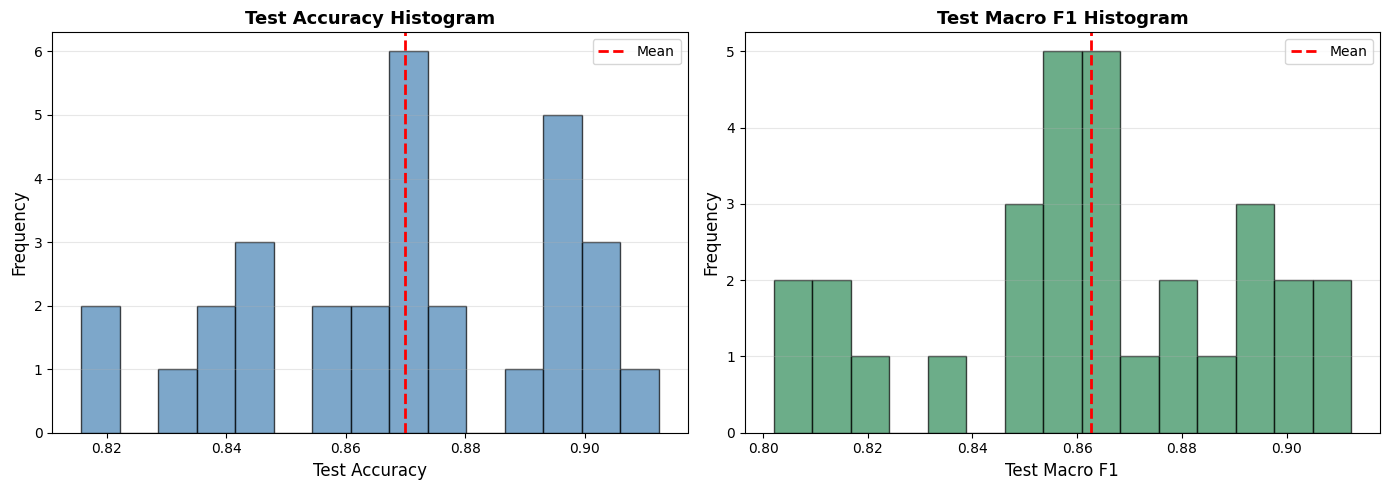

In [25]:
# Plot distributions for runs
plot_multi_run_distributions(multi_run_results, aggregated_stats)


CONFIG C: BEST vs WORST RUN COMPARISON
Best Run:  #25 (seed=67) - Acc: 0.9124, F1: 0.9123
Worst Run: #11 (seed=53) - Acc: 0.8157, F1: 0.8020


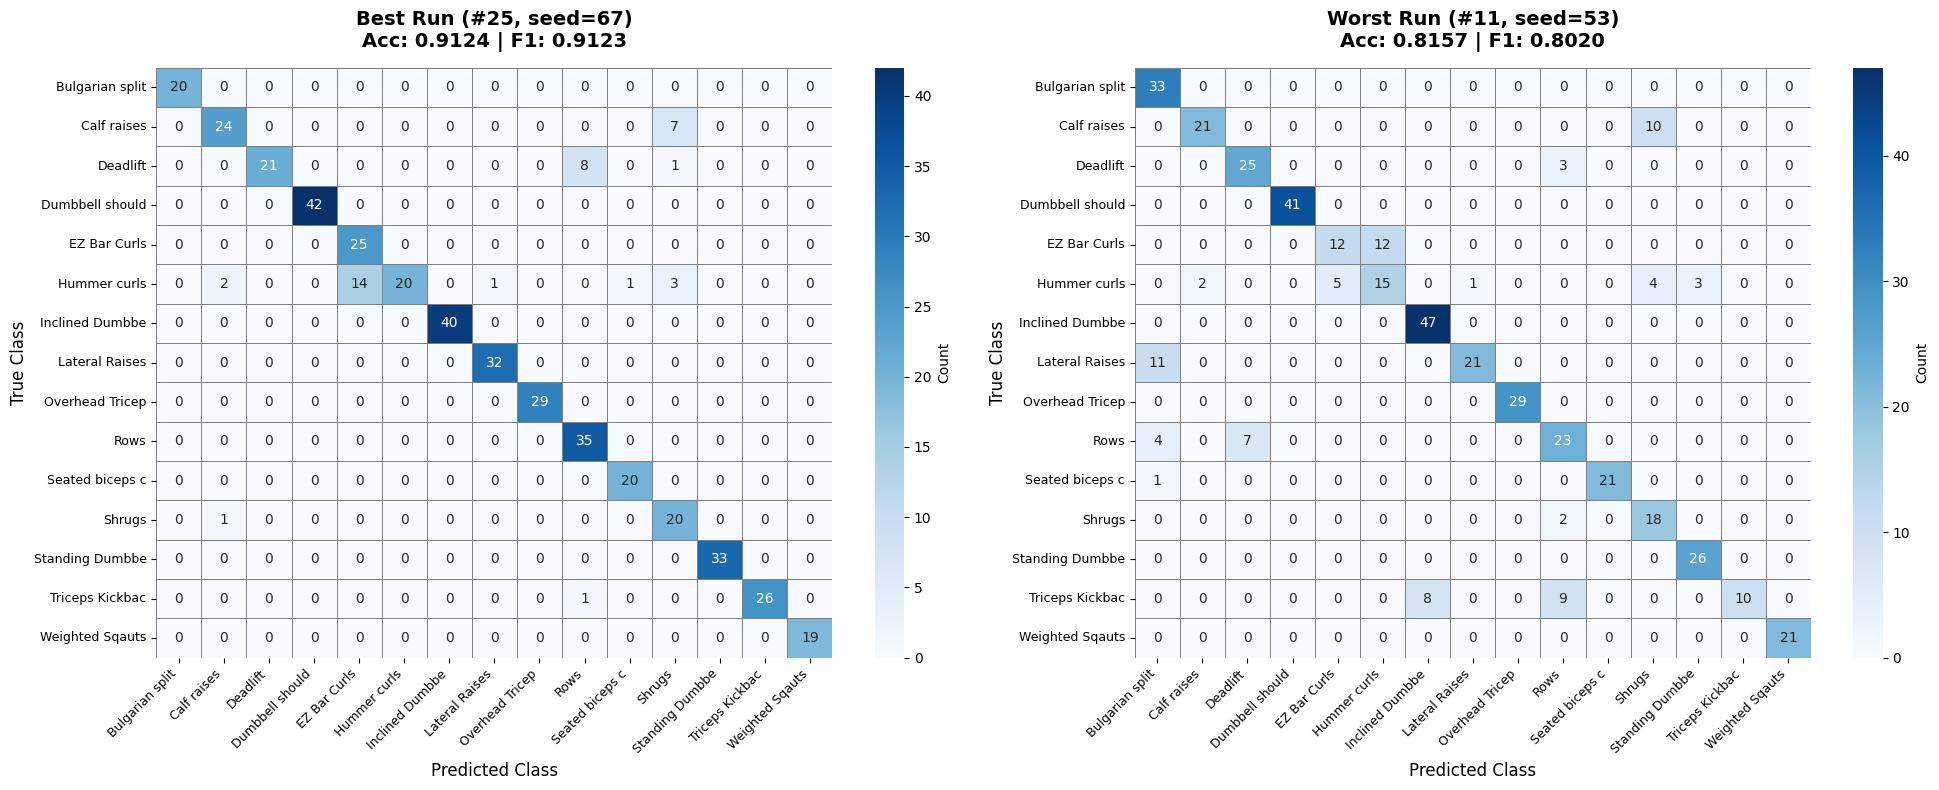


Per-Class F1 Comparison (Best vs Worst):
       Best Run  Worst Run  Difference
Class                                 
0        1.0000     0.8049      0.1951
1        0.8276     0.7778      0.0498
2        0.8235     0.8333     -0.0098
3        1.0000     1.0000      0.0000
4        0.7812     0.5854      0.1959
5        0.6557     0.5263      0.1294
6        1.0000     0.9216      0.0784
7        0.9846     0.7778      0.2068
8        1.0000     1.0000      0.0000
9        0.8861     0.6479      0.2382
10       0.9756     0.9767     -0.0011
11       0.7692     0.6923      0.0769
12       1.0000     0.9455      0.0545
13       0.9811     0.5405      0.4406
14       1.0000     1.0000     -0.0000


In [26]:
# Best vs worst run comparison
label_names = sorted(multi_run_results[0]['label_to_int'].keys())
ordered_labels = sort_labels_by_numeric_prefix(label_names)

print("\n" + "=" * 80)
print(f"CONFIG {SELECTED_CONFIG}: BEST vs WORST RUN COMPARISON")
print("=" * 80)
comparison_df = plot_best_worst_comparison(multi_run_results, ordered_labels)

### Best vs Worst Run Comparison

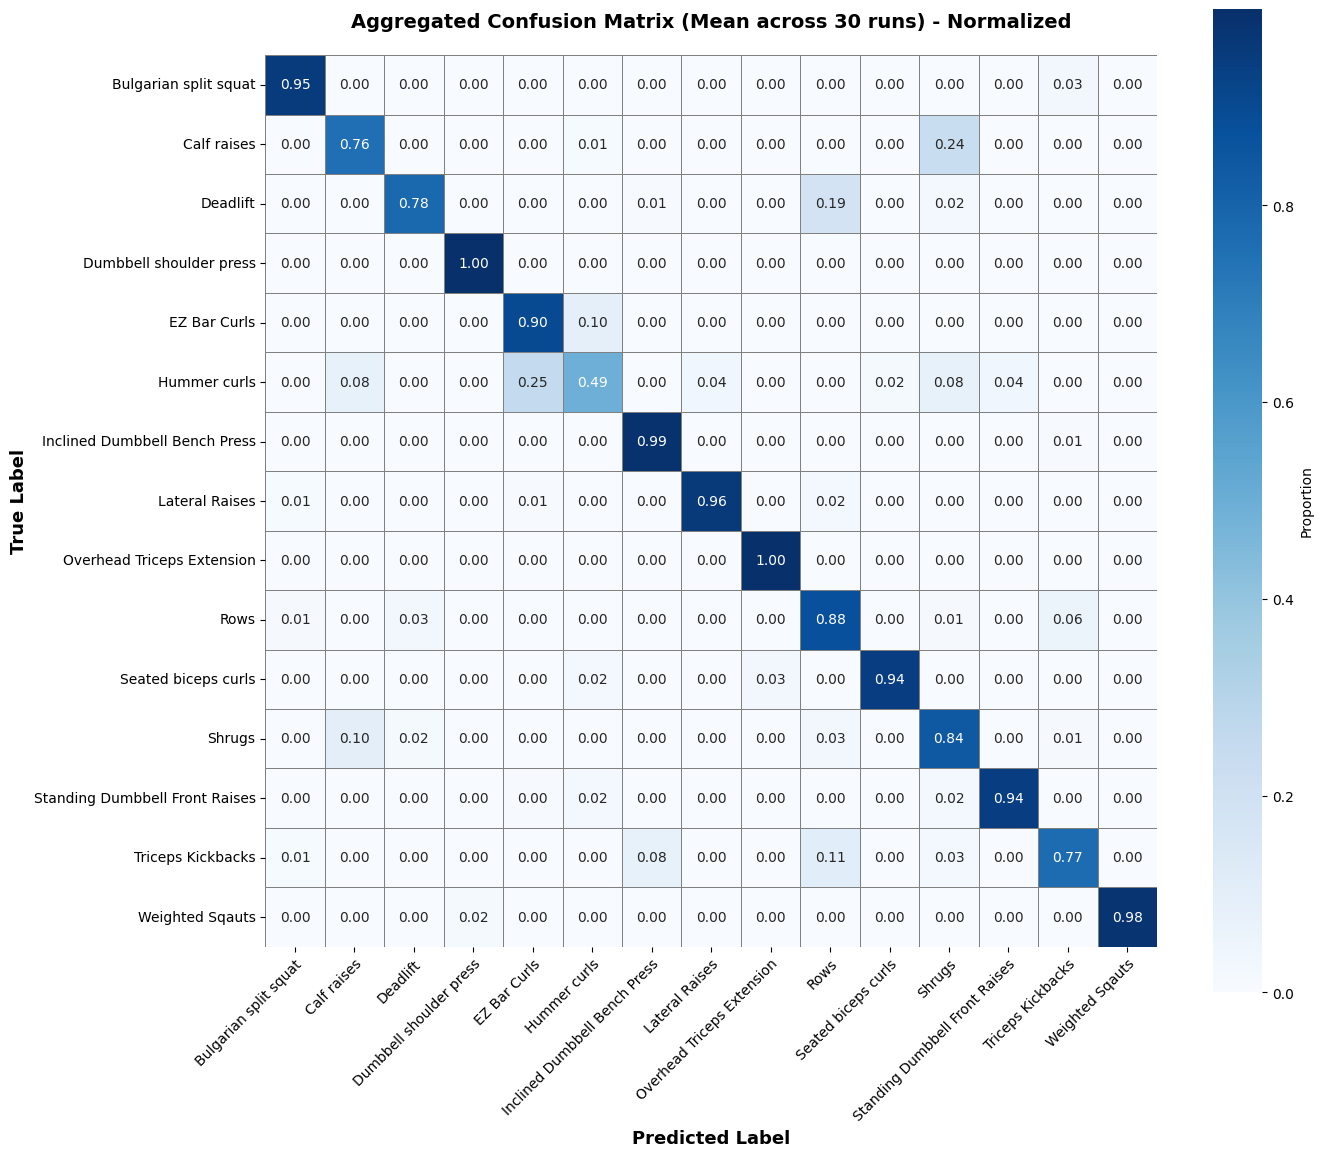

array([[2.54666667e+01, 0.00000000e+00, 6.66666667e-02, 0.00000000e+00,
        0.00000000e+00, 1.00000000e-01, 0.00000000e+00, 0.00000000e+00,
        3.33333333e-02, 1.00000000e-01, 3.33333333e-02, 6.66666667e-02,
        0.00000000e+00, 8.00000000e-01, 0.00000000e+00],
       [0.00000000e+00, 2.21000000e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.93333333e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e-01, 0.00000000e+00, 2.15333333e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.00000000e-01, 0.00000000e+00,
        0.00000000e+00, 5.13333333e+00, 0.00000000e+00, 5.66666667e-01,
        0.00000000e+00, 3.33333333e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.65666667e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+0

In [27]:
plot_aggregated_confusion_matrix(
    multi_run_results,
    label_names=ordered_labels,
    desired_class_order=ordered_labels,
    normalize=True
)

In [11]:
# Get best run for detailed analysis
best_run = max(multi_run_results, key=lambda x: x['test_metrics']['macro_f1'])

print(f"🏆 Best Run Performance (Config {SELECTED_CONFIG} - {SELECTED_VIEW}):")
print(f"   Accuracy: {best_run['test_metrics']['accuracy']:.4f}")
print(f"   Macro F1: {best_run['test_metrics']['macro_f1']:.4f}")

🏆 Best Run Performance (Config C - front):
   Accuracy: 0.9190
   Macro F1: 0.9238


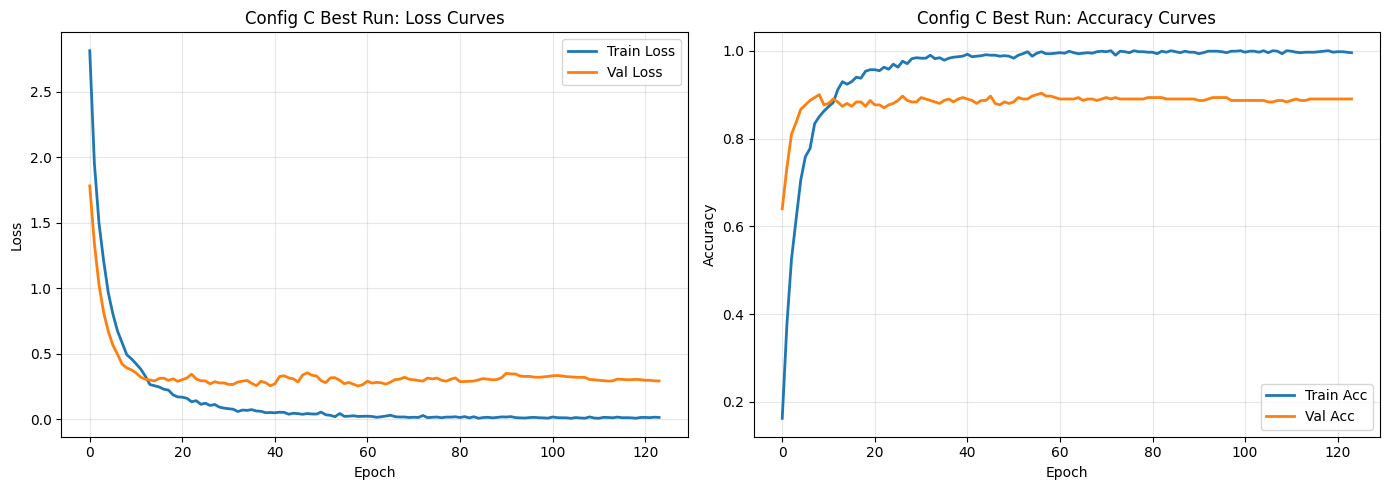

In [12]:
# Plot training history for best run
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(best_run['history']['loss'], label='Train Loss', linewidth=2)
axes[0].plot(best_run['history']['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Config {SELECTED_CONFIG} Best Run: Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(best_run['history']['accuracy'], label='Train Acc', linewidth=2)
axes[1].plot(best_run['history']['val_accuracy'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Config {SELECTED_CONFIG} Best Run: Accuracy Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Per-Class F1 Scores

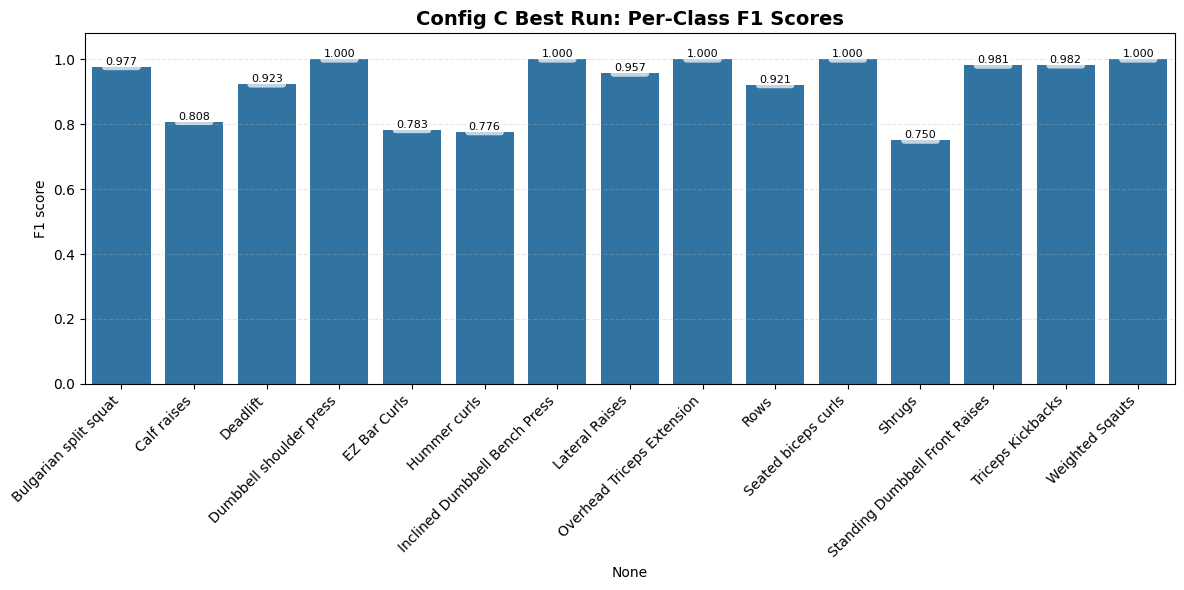

In [13]:
# Per-class F1 scores for best run
idx_to_label = {int(k): v for k, v in best_run['int_to_label'].items()}

fig, ax = plt.subplots(figsize=(12, 6))
plot_per_class_f1_scores(
    best_run['test_metrics']['per_class_f1'],
    idx_to_label,
    desired_class_order=ordered_labels,
    ax=ax
)
ax.set_title(f'Config {SELECTED_CONFIG} Best Run: Per-Class F1 Scores', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

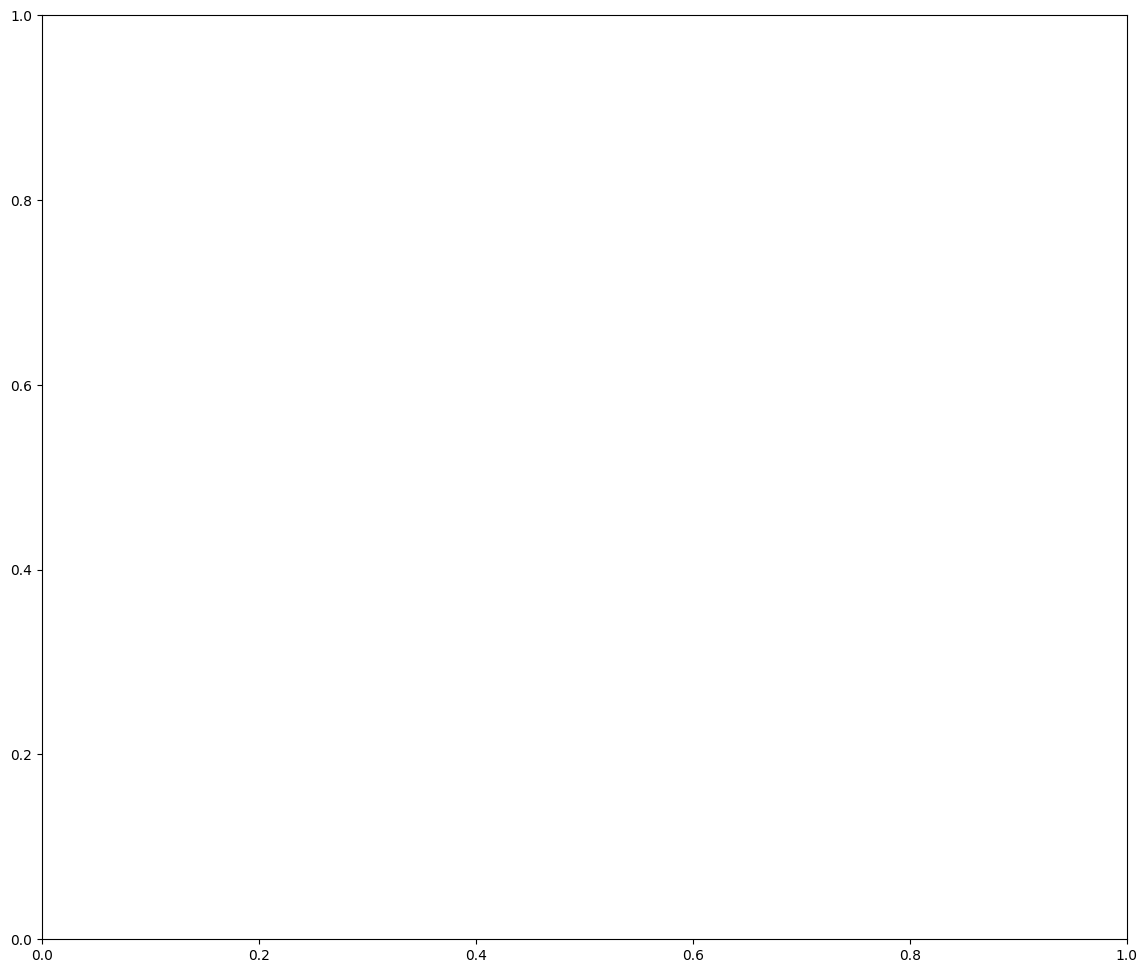

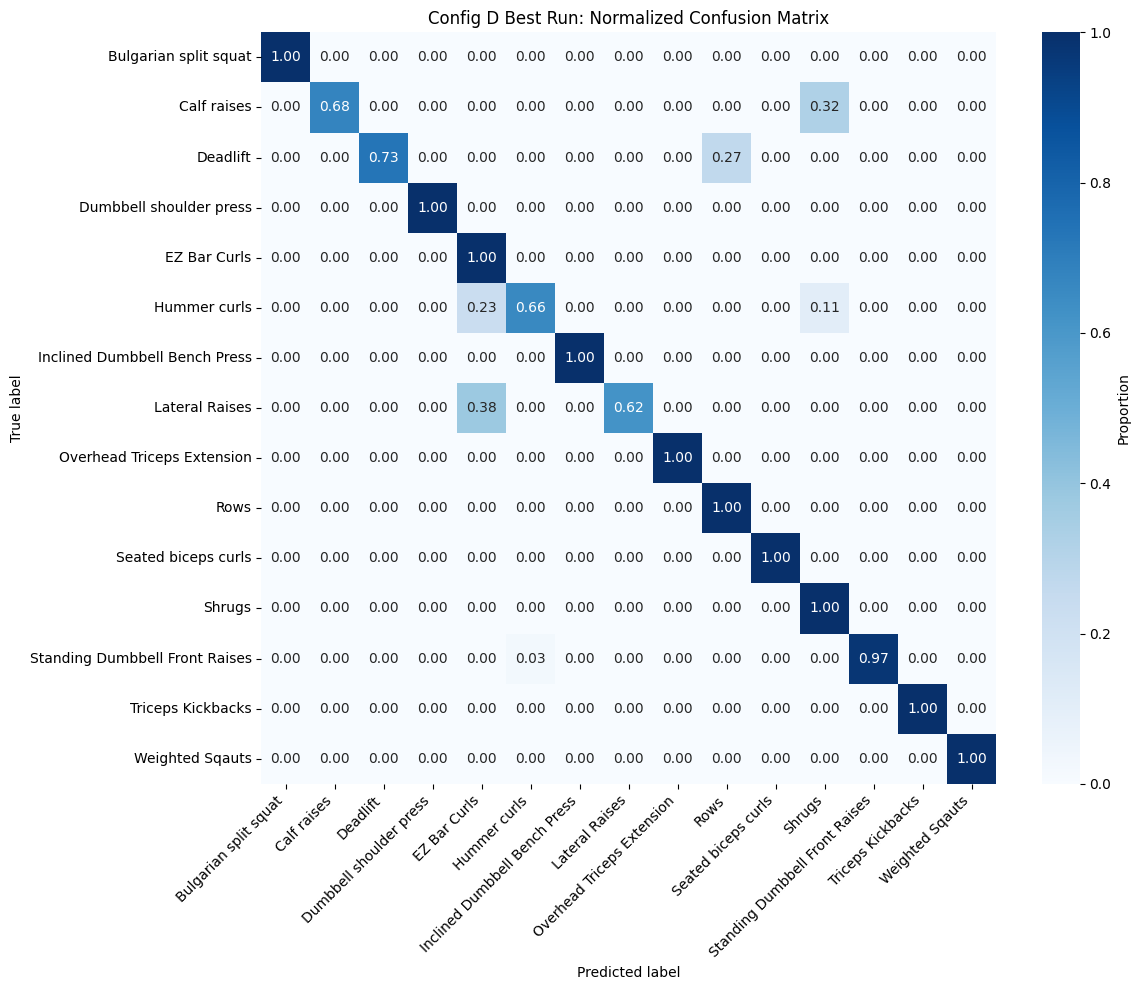

<Figure size 640x480 with 0 Axes>

In [22]:
# Confusion matrix for best run
conf_matrix = np.array(best_run['test_metrics']['confusion_matrix'])

fig, ax = plt.subplots(figsize=(14, 12))
plot_confusion_matrix_from_metrics(
    conf_matrix,
    current_class_order=label_names,
    desired_class_order=ordered_labels,
    normalize=True,
    title=f'Config {SELECTED_CONFIG} Best Run: Normalized Confusion Matrix'
)
plt.tight_layout()
plt.show()

# Final summary

In [14]:
print("=" * 80)
print(f"FINAL SUMMARY: CONFIG {SELECTED_CONFIG} ({config_info['name']}) - {SELECTED_VIEW.upper()} VIEW")
print("=" * 80)
print(f"\nConfiguration Details:")
print(f"  Feature type: {config_info['feature_type']}")
print(f"  Number of features: {config_info['num_features']}")
print(f"  Description: {config_info['description']}")

print(f"\nResults (30 runs):")
print(f"  Test Accuracy: {aggregated_stats['test_accuracy']['mean']:.4f} ± {aggregated_stats['test_accuracy']['std']:.4f}")
print(f"  Test Macro F1: {aggregated_stats['test_macro_f1']['mean']:.4f} ± {aggregated_stats['test_macro_f1']['std']:.4f}")
print(f"  Accuracy Range: [{aggregated_stats['test_accuracy']['min']:.4f}, {aggregated_stats['test_accuracy']['max']:.4f}]")
print(f"  F1 Range: [{aggregated_stats['test_macro_f1']['min']:.4f}, {aggregated_stats['test_macro_f1']['max']:.4f}]")

print(f"\nBest Run:")
print(f"  Accuracy: {best_run['test_metrics']['accuracy']:.4f}")
print(f"  Macro F1: {best_run['test_metrics']['macro_f1']:.4f}")
print("=" * 80)

FINAL SUMMARY: CONFIG C (Base + Specialized) - FRONT VIEW

Configuration Details:
  Feature type: base_specialized
  Number of features: 33
  Description: 19 base + 14 specialized discrimination features

Results (30 runs):
  Test Accuracy: 0.8542 ± 0.0320
  Test Macro F1: 0.8455 ± 0.0372
  Accuracy Range: [0.7596, 0.9190]
  F1 Range: [0.7270, 0.9238]

Best Run:
  Accuracy: 0.9190
  Macro F1: 0.9238


---

## (Optional) Load & Compare Multiple Configurations

Run this section after running multiple configurations to compare their results.

In [14]:
# Load results from saved multi-run folders (after running multiple configs)
import json
from pathlib import Path

def load_multi_run_stats(results_dir: str) -> dict:
    """Load aggregated stats from a multi-run results folder."""
    stats_path = Path(results_dir) / 'aggregated_stats.json'
    if stats_path.exists():
        with open(stats_path, 'r') as f:
            return json.load(f)
    return None

# Define result directories for each config (point directly to multi_run folders)
result_dirs = {
    'A': PROJECT_ROOT / 'output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_003',
    'B': PROJECT_ROOT / 'output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_007',
}

# Load stats directly from specified folders
all_stats = {}
for config_name, multi_run_folder in result_dirs.items():
    if multi_run_folder.exists():
        stats = load_multi_run_stats(str(multi_run_folder))
        if stats:
            all_stats[config_name] = stats
            print(f"✅ Loaded Config {config_name} from {multi_run_folder.name}")
        else:
            print(f"⚠️  Config {config_name}: No aggregated_stats.json found in {multi_run_folder}")
    else:
        print(f"⚠️  Config {config_name}: Directory not found - {multi_run_folder}")

print(f"\nLoaded {len(all_stats)} configurations for comparison")

✅ Loaded Config A from multi_run_003
✅ Loaded Config B from multi_run_007

Loaded 2 configurations for comparison


In [15]:
# Compare all loaded configurations
if len(all_stats) >= 2:
    print("=" * 80)
    print("CONFIGURATION COMPARISON")
    print("=" * 80)
    
    comparison_data = []
    for config_name, stats in sorted(all_stats.items()):
        config_detail = CONFIG_MAP.get(config_name, {'name': 'Unknown', 'num_features': '?'})
        comparison_data.append({
            'Config': f"{config_name} ({config_detail['name']})",
            'Features': config_detail['num_features'],
            'Accuracy': f"{stats['test_accuracy']['mean']:.4f} ± {stats['test_accuracy']['std']:.4f}",
            'Macro F1': f"{stats['test_macro_f1']['mean']:.4f} ± {stats['test_macro_f1']['std']:.4f}",
            'Acc Range': f"[{stats['test_accuracy']['min']:.4f}, {stats['test_accuracy']['max']:.4f}]",
            'F1 Range': f"[{stats['test_macro_f1']['min']:.4f}, {stats['test_macro_f1']['max']:.4f}]"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    print(comparison_df.to_string(index=False))
    
    # Find best config
    best_config = max(all_stats.keys(), key=lambda x: all_stats[x]['test_macro_f1']['mean'])
    best_f1 = all_stats[best_config]['test_macro_f1']['mean']
    print(f"\n🏆 Best Configuration: {best_config} ({CONFIG_MAP[best_config]['name']}) with Macro F1 = {best_f1:.4f}")
    print("=" * 80)
else:
    print("⚠️  Need at least 2 configurations to compare. Run more configs first.")

CONFIGURATION COMPARISON


                Config  Features        Accuracy        Macro F1        Acc Range         F1 Range
          A (Baseline)        19 0.8926 ± 0.0264 0.8774 ± 0.0288 [0.8378, 0.9490] [0.8116, 0.9324]
B (Base + Specialized)        37 0.8374 ± 0.0641 0.8343 ± 0.0653 [0.6095, 0.9144] [0.6013, 0.9155]

🏆 Best Configuration: A (Baseline) with Macro F1 = 0.8774


---

## (Optional) Load & Plot Aggregated Confusion Matrix from Saved Results

Load a saved multi-run result and plot its aggregated confusion matrix across all 30 runs.

✅ Loaded 30 runs from multi_run_003


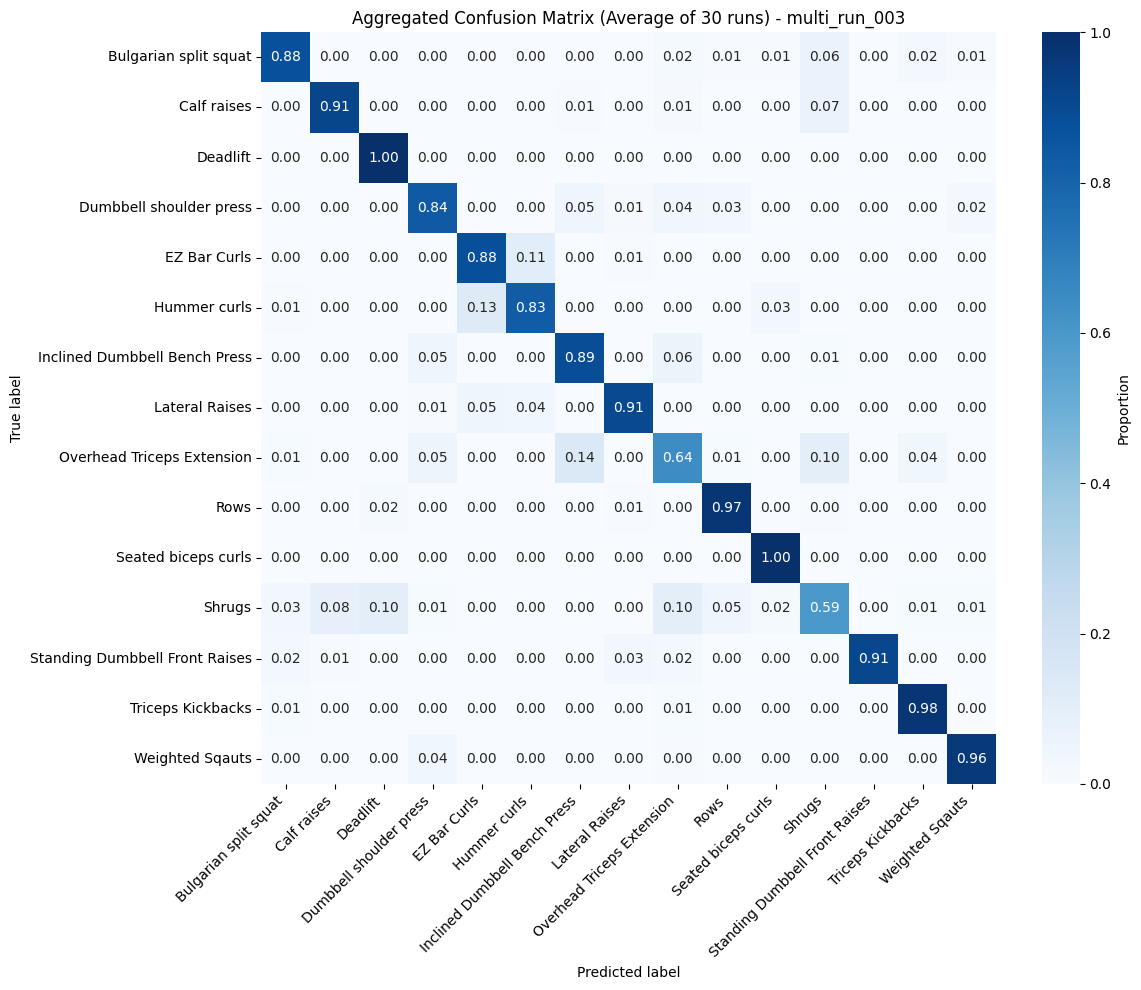

<Figure size 640x480 with 0 Axes>


📊 Confusion Matrix Statistics:
  Total runs averaged: 30
  Classes: 15


In [17]:
# Load all runs from a saved multi-run folder and compute aggregated confusion matrix
import json
from pathlib import Path

# Specify the multi-run folder to load (update path as needed)
MULTI_RUN_PATH = PROJECT_ROOT / 'output/exer_recog/exp_06_pose_mlp_temporal/side/multi_run_003'

# Load all runs data
all_runs_path = MULTI_RUN_PATH / 'all_runs.json'
if all_runs_path.exists():
    with open(all_runs_path, 'r') as f:
        loaded_runs = json.load(f)
    
    print(f"✅ Loaded {len(loaded_runs)} runs from {MULTI_RUN_PATH.name}")
    
    # Extract label names and create ordered list
    first_run = loaded_runs[0]
    label_names = sorted(first_run['label_to_int'].keys())
    ordered_labels = sort_labels_by_numeric_prefix(label_names)
    num_classes = len(label_names)
    
    # Aggregate confusion matrices
    aggregated_cm = np.zeros((num_classes, num_classes), dtype=np.float32)
    for run in loaded_runs:
        cm = np.array(run['test_metrics']['confusion_matrix'])
        aggregated_cm += cm
    
    # Average across all runs
    aggregated_cm /= len(loaded_runs)
    
    # Plot aggregated confusion matrix
    plot_confusion_matrix_from_metrics(
        aggregated_cm,
        current_class_order=label_names,
        desired_class_order=ordered_labels,
        normalize=True,
        title=f'Aggregated Confusion Matrix (Average of {len(loaded_runs)} runs) - {MULTI_RUN_PATH.name}'
    )
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Confusion Matrix Statistics:")
    print(f"  Total runs averaged: {len(loaded_runs)}")
    print(f"  Classes: {num_classes}")
    
else:
    print(f"⚠️  File not found: {all_runs_path}")
    print(f"   Make sure to run training first or update MULTI_RUN_PATH")